


# *Data Science Unit 4 Sprint 2 Assignment 4*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Apply regularization techniques to your model. 

**Don't forgot to switch to GPU on Colab!**


## Objective 

In lecture, you were exposed to Lp space reguarlization, Max Norn weight constraints, and dropout. 

In this assignment, you will run several experiments in order to perform a deeper analysis on the effects that various regularization techniques have model performance and on the learned model weights. 

By the end of this assignment, these regularization techniques should no longer feel like black boxes to you (i.e. completely mysterious as to how they work.) 


#### Import libraries

In [1]:
# native libraries 
import os
from time import time 

# data analysis libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning libraries 
from keras import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten, Dense, Dropout
from keras.layers import ReLU
from keras.initializers import GlorotUniform

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# regularizers 
from keras.regularizers import l2, l1
from keras.constraints import MaxNorm

# required for compatibility between sklearn and keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

# native python unit test library
from unittest import TestCase

%matplotlib inline

-----

# $L_p$ Space Regularization 

## Bridging Theory and Practice 

Because the idea of infinitely many vector spaces, each with their very own distance metric for measuring distance differently can seem very abstract, we are going to take that distance metric general formula and look at a few special cases by writing custom regularization functions and taking note of their effect a the model's learning outcomes. 

Don't forget to review the theory of $L_p$ Space Regularization in the guided project. 

Also, watch this video if you haven't already. 

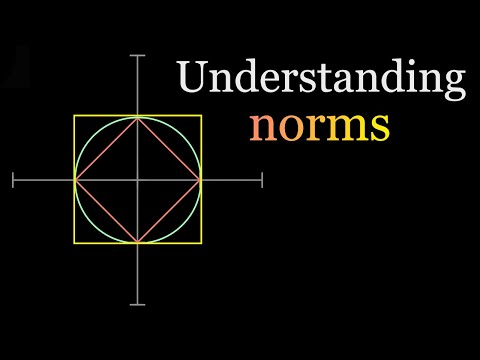

In [2]:
# check out this video for an animated explaination of Lp Space and distance metrics 
from IPython.display import YouTubeVideo
YouTubeVideo('FiSy6zWDfiA', width=800, height=300)

### Distance Metric General Formula
$${\displaystyle \left\|x\right\|_{p}=\left(|x_{1}|^{p}+|x_{2}|^{p}+\dotsb +|x_{n}|^{p}\right)^{1/p}.}$$

Let's create a class for the distance metric general formula.


There are 2 classes below: 

```python
class Test_distance_metric_solution()
```

You don't need to change anything in this class. This class is here in order to make sure that you calculate each portion of the distance metric general formula correctly. 


```python
class Lp_distance_metric_general_formula()
```

This is the class that you will complete. 

Each of the non `__call__` methods calculate one portion of the distance metric general formula. 

Breaking up each portion of the formula into a separate method is actually unnecessary. 

Including the entire calculation of the general formula into a single method is ideal, however it is more difficult to write granular unit tests that way. 

So, for instructional purposes, it was broken up into 3 methods. However, outside of an academic environment, we would only need the `__init__` and `__call__` methods. 

Having said that, it is good for you to see how a custom unit test class is used to test the calculations of another class. This is a portion of what software engineering looks like. Get used to it. You'll need good software engineering practices to make it in the world. You'll learn more about this in your CS unit. For now, consider it a bit of foreshadowing. 

In [3]:
class Test_distance_metric_solution(TestCase):
    """
    This is a unit test class desgined to make sure that the student calcualtes each component 
    of the Distance Metric General Formula correctly. Thereby getting real-time feedback and correction. 
    """
    
    def test_squared_vector_comps(self, test_array):
        """
        This test makes sure that student calculate the sum_of_squared_comp correctly. 
        """
        answer = np.array([1., 4.])
        # error message in case if test case got failed
        message = "you did not calcualte sum_of_squared_comp correctly"
        # assert function() to check if values are almost equal
        np.testing.assert_array_equal(answer, test_array,  err_msg=message)
        
        
    def test_sum_of_squared_comp(self, test_sum):
        """
        This test makes sure that student calculate the sum_of_squared_comp correctly. 
        """
        answer = 5
        # error message in case if test case got failed
        message = "you did not calcualte sum_of_squared_comp correctly"
        # assert function() to check if values are almost equal
        np.testing.assert_array_equal(answer, test_sum,  err_msg=message)
        
    def test_vector_norm(self, test_norm):
        """
        This test makes sure that student calculate the vector_norm correctly. 
        """
        answer = 2.236
        decimalPlace = 3
        # error message in case if test case got failed
        message = "you did not calcualte sum_of_squared_comp correctly"
        # assert function() to check if values are almost equal
        self.assertAlmostEqual(answer, test_norm,  decimalPlace, message)        

### Fill in the missing code in the class below

In [4]:
class Lp_distance_metric_general_formula(object):
    """
    This class takes the Lp distance metric general formual and sets p equal to a value provided by the user. 
    This has the effect of deriving a distance metric for a specific metric space and calcualting the distance 
    of a vector in that metric space.
    
    Example
    -------
    If the user sets p = 2, then the euclidean distance formula is derived.
    If the user sets p = 1, then the taxicab distance formula is derived. 
    
    Note
    ----
    It is possible to use p values less than 1 but those are special cases that we will ignore. 
    These special values are interesting for academic purposes but in practice you very likely won't need to know 
    about them.
    """

    def __init__(self, p=2, reg_strength = 1.0):
        """
        Parameters
        ----------
        
        p: int or float
            p value used for calculating the distance of a vector in a certain metric space
            
        reg_strength: int or float
            usually set to a value less than 1.0 to decrease the strength of the distance metric when used as a model regularizer
            keep this value at 1.0 when measureing vector norms (i.e. vector lengths)
        """
        
        assert p >=1 , "p value must be greater than or equal to 1"
        
        self.p = p
        self.reg_strength = reg_strength
                
    def calc_squared_vector_comps(self):
    
        # raise each vector component in self.x to the power of p
        # save result to self.squared_vector_comps
       self.squared_vector_comps = self.x**(self.p)
        
    def calc_sum_of_squared_comp(self):
        # take the sum of the squared components in self.squared_vector_comps
        # save to self.sum_of_squared_comp
        # hint: use tf.reduce_sum
        self.sum_of_squared_comp = tf.reduce_sum(self.squared_vector_comps,0)
        
        
    def calc_vector_norm(self):
        
        # take the 1/p root of the self.sum_of_squared_comp in order to calculate the norm, i.e. ||x||
        # save result to self.vector_norm
        self.vector_norm = (self.sum_of_squared_comp)**(1/self.p)
        
        
    def __call__(self, x):
        """
        This method calcualtes the distance (i.e. norm) for vector x in Lp space for a value p given by the use
        
        ‖𝑥‖𝑝 = (|𝑥_1|^𝑝 + |𝑥_2|^𝑝 + ⋯ +|𝑥_𝑛|^𝑝 )^1/𝑝
        
        Parameters
        ----------
        x: N-dimsional numpy array or tensorflow tensor of floats 
            x is our vector, could be a weight vector but any vector is valid 
            
            
        HINT
        -----
        You must use self.p when calculating squared_vector_comps and vector_norm
        """
        
        self.x = x
        
        # calculate these parts |𝑥_i|^𝑝
        self.calc_squared_vector_comps()
        
        # calcualte this |𝑥_1|^𝑝 + |𝑥_2|^𝑝 + ⋯ +|𝑥_𝑛|^𝑝
        self.calc_sum_of_squared_comp()
        
        # calculate this (|𝑥_1|^𝑝 + |𝑥_2|^𝑝 + ⋯ +|𝑥_𝑛|^𝑝 )^1/𝑝
        self.calc_vector_norm()
        
        # return the vector norm scaled by a regularization penality
        # we say penality because the value is usually less than 1.0 thereby scaling down the norm
        return self.reg_strength * self.vector_norm

------
### Unit Test your code

You know you wrote your class correctly when all the unit tests pass. 

So the code in the following cell should run without throwing a single error. 

Protip: you can comment out 2nd and 3rd unit test in order to test your results for the first method and then uncomment as you go. Feel free to create a new cell and run your own testing there. 

In [5]:
# instantiate the unit test class that will check the calculates of Lp_distance_metric_general_formula's methods
tests = Test_distance_metric_solution()

# instantiate Lp_distance_metric_general_formula, set p = 2 in order to derive the euclidean distance metric
lp = Lp_distance_metric_general_formula( p=2, reg_strength = 1.0)

# don't change this test_vector
# Test_distance_metric_solution assumes that you're using ths exact test_vector
test_vector = np.array([1., 2.])
lp(test_vector)

# test the calculations that are perform in each of the following lp class methods 
tests.test_squared_vector_comps(lp.squared_vector_comps)
tests.test_sum_of_squared_comp(lp.sum_of_squared_comp)
tests.test_vector_norm(lp.vector_norm.numpy())

In [6]:
# note: because we use tf.reduce_sum to calculate sum_of_squared_comp
# the result is inside of a tensor and we need to use .numpy() to get the scalar out of the tensor 
print (lp.vector_norm)

tf.Tensor(2.2360679774997894, shape=(), dtype=float64)


In [7]:
print (lp.vector_norm.numpy())

2.2360679774997894


----

### Apply our $L_p$ Space Class

Next we will use our distance metric class in order to calculate the euclidean and taxicab distance of our vector below. 

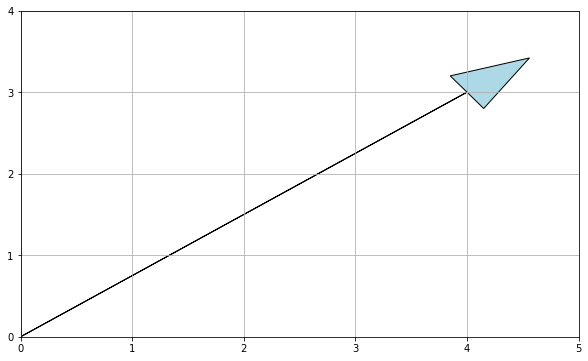

In [8]:
# W is a 2D vector with an x and y component, i.e. (x, y) = (4,3)
w = np.array([4., 3.])

# origin point - we need to specify the starting point for plotting
origin = np.array([0,0])

plt.figure(figsize=(10, 6))
ax = plt.axes()

ax.arrow(origin[0], origin[1], w[0], w[1], head_width=0.5, head_length=0.7, fc='lightblue', ec='black')

plt.grid()
plt.yticks(np.arange(0,5))
plt.xticks(np.arange(0,6));

## Derive Euclidean Distance from the General Formula 

This is the general formula for distance metrics. Where we have an N-dimensional weight vector **w**. Notice that the general formula has a vector component for each of the N dimensions. Hence, it is the general formula.

$${\displaystyle \left\|\textbf{w}\right\|_{p}=\left(|w_{1}|^{p}+|w_{2}|^{p}+\dotsb +|w_{n}|^{p}\right)^{1/p}.}$$
 

Let N = 2 such that our weight vector now exists in 2 dimensional space. 

Let p = 2 such that our weight vector's distance will be calculated in $L_{p=2}$ space 

In which case our general formula gets reduced from N-dimensions to 2-dimensions. So now we only need to consider a distance formula for a vector with 2 components, one for each dimension.

$$||\textbf{w}||_{p=2} = ((x_2 - x_1)^2 + (y_2 - y_1)^2)^{1/2}$$

Now just re-express the square root and we arrive at the familiar Euclidean Distance from high school algebra. 

$$||\textbf{w}||_{p=2} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$


You might be wondering about why the general case doesn't have differences for the components but the Euclidean Distance does explicitly show the component wise differences. It is common in mathematics to suppress certain information, especially if that information is "obvious" - however what is obvious is highly relative. 

The general formula assumes that the vector starts at the origin, in which case, there's no need to show the subtraction of zero from a vector component. 

Assuming that our vector starts at the origin (and it does) the formula can be reduced to 

$$||\textbf{w}||_{p=2} = \sqrt{(x_2 - 0)^2 + (y_2 - 0)^2}$$

$$||\textbf{w}||_{p=2} = \sqrt{x_2^2 + y_2^2}$$

### Euclidean distance of our Vector 

With **p=2** in our `Lp_distance_metric_general_formula` class, we can calculate the euclidean distance of our vector **w**. I encourage you to either solve the euclidean distance of our vector either in your head or on paper to prove to yourself that the above formula that we derived works and gives you `5` as an answer. 

In [9]:
w_p2 = np.sqrt((3**2)+(4**2))
w_p2



5.0

-----

## Derive Taxicab Distance from the General Formula 

This is the general formula for distance metrics. Where we have an N-dimensional weight vector **w**. Notice that the general formula has a vector component for each of the N dimensions. Hence, it is the general formula.

$${\displaystyle \left\|\textbf{w}\right\|_{p}=\left(|w_{1}|^{p}+|w_{2}|^{p}+\dotsb +|w_{n}|^{p}\right)^{1/p}.}$$
 

Let N = 2 such that our weight vector now exists in 2 dimensional space. 

Let p = 1 such that our weight vector's distance will be calculated in $L_{p=1}$ space 


In which case our general formula gets reduced from N-dimensions to 2-dimensions. So now we only need to consider a distance formula for a vector with 2 components, one for each dimension.

$$||\textbf{w}||_{p=1} = ((x_2 - x_1)^1 + (y_2 - y_1)^1)^{1/1}$$

There's no need to express all those 1's

$$||\textbf{w}||_{p=1} = (x_2 - x_1) + (y_2 - y_1) $$

Assuming that our vector starts at the origin (which it does)

$$||\textbf{w}||_{p=1} = (x_2 - 0) + (y_2 - 0) $$



$$||\textbf{w}||_{p=1} = x + y $$

We have just derived the Taxicab distance metric from the general formula. The above equation tells us to add up all the steps in the x and y direction in order to calculate the Taxicab distance.

### Taxicab distance of our Vector 

With **p=1** in our `Lp_distance_metric_general_formula` class, we can calculate the taxicab distance of our vector **w**. This distance we can easily calculate in our head. Look at the plot of the vector and simply add up all the x and y components, i.e. count up all the steps you have to take in order to "walk" from the origin to the head of the vector. Do this to prove to yourself that the taxicab distance of our vector is `7`. 

In [10]:
# use Lp_distance_metric_general_formula class to calculate the taxicab distance of w

# YOUR CODE HERE
w_p1 = 4+3
w_p1

7

### Elastic Net Distance 


Elastic Net is a combination of L1 and L2. Compare the geometry below. 

![](https://ds100.org/sp17/assets/notebooks/linear_regression/norm_balls.png)

The mathematical derivation of the distance metric for  $L_{p=3/2}$ space will be left to you as an optional exercise. 

In [11]:
# use Lp_distance_metric_general_formula class to calculate the Elastic Net distance of w

# YOUR CODE HERE
net_distance = w_p2 - w_p1
net_distance

-2.0

-----

## Use Custom Lp Space class in modeling

Let's create a function that returns complied keras models so that we can run an experiment in order to compare the modeling results from using a keras L2 and our custom L2 regularizer. 

-----
### Load Data

In [12]:
def load_data():
    """
    Load in and normalize image data set
    """
    
    # load in our dataset 
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # normalize pixel values between 0 and 1 
    max_pixel_value = X_train.max()
    X_train, X_test = X_train /max_pixel_value , X_test / max_pixel_value
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [14]:
# this is equal to the number of nodes in the output layer
N_labels = len(np.unique(y_train))
N_labels

10

In [15]:
def create_model(reg=None):
    # instantiate Sequential class
    model = Sequential([

    # flatten images 
        Flatten(input_shape=(28,28)), # images will be flattend out to 784 dims row vectors 

    # hidden layer 1
        Dense(500, kernel_regularizer=reg),

    # act func 1
        ReLU(negative_slope=0.01),

    # output layer 
        Dense(10, activation ="softmax")   
    ])

    # compile model 
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer= "adam", 
                  metrics=["accuracy"])
    
    return model

----

## Experiment 1: Calculate vector lengths using Keras and Custom Regularizer



If you read the [**Keras Documentation**](https://keras.io/api/layers/regularizers/) for their implementation of L2 regularization you'll see this:

    The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x))
    
Notice that Keras isn't taking the square root for L2 where as we are take the square root. 

Why isn't Keras taking the square root? I don't know but we will stay true to the math and take the square root for our implementation of L2 regularization. 



In [16]:
custom_l2 = Lp_distance_metric_general_formula(p=2, reg_strength = 1.0)
# the length of the W vector from above as calcualted by the formula that we derived 
custom_l2(w).numpy()

5.0

In [17]:
from keras.regularizers import L2
keras_l2 = L2(l2=1.0)
# again Keras doesn't take the square root
keras_l2(w).numpy()

25.0

In [18]:
# but if we take the square root, then we get the same answer that our custom regularizer class gives us 
np.sqrt(keras_l2(w).numpy())

5.0

----
## Experiment 2: Compare Keras L2 and Custom L2 regularization in a model


### Use Keras Built-in L2 regularizer 

Make sure to use the same regularization strength in the Keras pre-built L2 regularizer and in our custom L2 regularizer.

In [19]:
model_keras_l2 = create_model(reg=L2(l2=0.01))
keras_l2_results = model_keras_l2.fit(X_train, y_train,
                                      epochs=1,
                                      validation_data=(X_test, y_test), 
                                      workers=10) # check! You might not be able to use 10 processors on your machine 

1875/1875 [==============================] - 18s 2ms/step - loss: 1.6633 - accuracy: 0.7550 - val_loss: 0.7345 - val_accuracy: 0.7910


### Use Custom Regularization Class 

Make sure to use the same regularization strength in the Keras pre-built L2 regularizer and in our custom L2 regularizer.

In [20]:
# set p= 2 so that we are using the same L2 regularizer as above
lp = Lp_distance_metric_general_formula(p=2, reg_strength = 0.01)

In [ ]:
model_custom_l2 = create_model(reg=lp)
custom_l2_results = model_custom_l2.fit(X_train, y_train,
                                      epochs=1,
                                      validation_data=(X_test, y_test), 
                                      workers=10) # check! You might not be able to use 10 processors on your machine 

----
### Compare Model Results

Let's compare the modeling results between the two models. 

Whatever the specific test accuracies are, it should be the case that using our custom class leads to slightly better results than using the Keras version of $L_2$ regularization.

There a small difference between test accuracies, possible due to the random sampling for the initial weight values. But also possibly from the observation that we made above - Keras isn't taking the square root. 

In [22]:
_, keras_acc = model_keras_l2.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7345 - accuracy: 0.7910


In [ ]:
_, custom_acc = model_custom_l2.evaluate(X_test, y_test)


### Conclusion 

In this experiment, we have bridged the gap between the theory of **$L_p$ Space Regularization** and the practice of using the general formula as a starting point to derive and build our very own regularizers. 

This experiment (and the Perceptron that we build from scratch in Sprint 2 Module 1) are examples of **mathematical algorithms** - an algorithm in mathematics is a procedure, a description of a set of steps that can be used to solve a mathematical computation.

It's one thing to use open-source pre-built mathematical algorithms like Keras regularizers and Sklearn ML models but it's quite another thing to build them from scratch. 

In industry, you'll need to know when you should build something from scratch and when to use an open source solution. The rule of thumb is don't build it if someone else already has because maintaining the code and fixing bugs is something that other developers (ie. the open-source community) can spend their time on and you don't have to. But if an open source solution doesn't exist for a solution that you need, then you'll need to build it or try an alternative solution.

It's a good thing you're taking the time to practice building some mathematical algorithms from scratch. It's a very valuable skill to have. 

-----
# GridSearch Experiments 

The next set of experiments will all involve gridsearching regularization parameter values. 

The rest of the notebook will actually require very little coding on your part. Instead, the focus is for you to run those gridsearches and answer the questions at the end of each experiment. Those questions are designed to help you capture the insights that there are to learn from each of the experiments. 

All of the following experiments are designed to help you better understand the relationship between the various regularization techniques and how they affect model performance. 


### Build Model

Let's build out the model that we'll be using all throughout our experiments. 

Remember that **the whole point of regularization is to prevent overfitting.**


![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

Overfitting happens when are model's are too complex, so in order to see a benefit from the use of regularization techniques we need to build a relatively complex model. 

Having said that, you might not have the computational resource to be able to train a complex model in a reasonable amount of time. So if this describes you, then you might want to consider using `build_simple_model`. Otherwise, I recommend that you use `build_complex_model`. 

This notebook will be using  `build_complex_model` to run our experiments. 

**NOTE:** Whichever function you end up using to build a model, take time to read through the code and make sure you understand what is happening. 

In [24]:
def build_complex_model(Lp_reg=None, reg_penality=None, dropout_prob=0.0, maxnorm_wc=None):
    """
    Build and return a regularized 3 hidden layer FCFF model 
    
    Parameters
    ----------
    Lp_reg: None or object
        If object, Lp_reg is either l1 or l2 regularization 
        If None, that means that l1 or l2 regularization will not be used.
     
    reg_penality: None or float
        If float, reg_penality is a value typically between 1.0 and 0.0001
        This is the regularization strength for l1 or l2 
        
        
    dropout_prob: float
        This is the probability that dropout regularization will exclude a node from a training iteration. 
        If this value is 0.0, that means that dropout will not be used. 
        
    maxnorm_wc: None or float
        If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
        If None, that means that Max Norm regularization will not be used.
        
        
    Return
    ------
    model: complied Keras model
    """
    
    # if reg_type is not None, then pass in the penality strength to whatever form of Lp space regularization this is 
    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penality)
    else:
        Lp_regularizer = None
                
    if maxnorm_wc is not None:
        wc = MaxNorm(max_value=maxnorm_wc)
    else:
        wc = None


    # instantiate Sequential class
    model = Sequential([

    # flatten images 
    Flatten(input_shape=(28,28)),

    # hidden layer 1
    Dense(500, kernel_regularizer=Lp_regularizer , kernel_constraint=wc), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # act func 1
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 2
    Dense(250, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 3
    Dense(100, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # output layer   
    Dense(N_labels, activation="softmax")  

    ])
    # complie model 
    model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])
    
    return model

Again, only use `build_simple_model` instead of `build_complex_model` if you're working on a machine with very limited computational resource. 

In [ ]:
# def build_simple_model(Lp_reg=None, reg_penality=None, dropout_prob=0, maxnorm_wc=None):
#     """
#     Build and return a regularized 1 hidden layer FCFF model 
    
#     Parameters
#     ----------
#     Lp_reg: None or object
#         If object, Lp_reg is either l1 or l2 regularization 
#         If None, that means that l1 or l2 regularization will not be used.
     
#     reg_penality: None or float
#         If float, reg_penality is a value typically between 1.0 and 0.0001
#         This is the regularization strength for l1 or l2 
        
        
#     dropout_prob: float
#         This is the probability that dropout regularization will exclude a node from a training iteration. 
#         If this value is 0.0, that means that dropout will not be used. 
        
#     maxnorm_wc: None or float
#         If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
#         If None, that means that Max Norm regularization will not be used.
        
        
#     Return
#     ------
#     model: complied Keras model
#     """
    
#     if Lp_reg is not None:
#         Lp_regularizer = Lp_reg(reg_penality)
#     else:
#         Lp_regularizer = None

#     # instantiate Sequential class
#     model = Sequential([

#     # flatten images 
#     Flatten(input_shape=(28,28)),

#     # hidden layer 1
#     Dense(128,  kernel_regularizer=Lp_regularizer, kernel_constraint=maxnorm_wc), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
#     # act func 1
#     ReLU(negative_slope=0.01),
#     Dropout(p_dropout),

#     # output layer   
#     Dense(N_labels, activation="softmax")  

#     ])
#     # complie model 
#     model.compile(loss="sparse_categorical_crossentropy", 
#                  optimizer="adam", 
#                  metrics=["accuracy"])
    
#     return model

Since we'll be using Sklearn's GridserchCV class, we need to wrap our Keras models in `KerasClassifier`

In [25]:
# remember to wrap KerasClassifier around build_model for sklearn's GridsearchCV compatibility 
model = KerasClassifier(build_fn = build_complex_model)

-------

# Experiment 1: Identify the relationship between model performance and L2 penalty strength

![](https://www.researchgate.net/publication/334159821/figure/fig1/AS:776025558495234@1562030319993/Ridge-regression-variable-selection.png)

We are going to run a gridsearch soley on the l2 regularization penalty value and see the effect this has on model performance. 

By running a gridseach on only a single hyperparameter (while using the same data and model) we can isolate the effect of that hyperparameter. 

In [26]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # take note that Lp_reg penalty/strength values are in powers of 10 
    "reg_penality": [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    # Since we only want to test l2, provide l2 as the sole option 
    "Lp_reg": [l2],
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider chanign epochs to 1 if the gridsearche run-time are too long for you
    "epochs": [1] 
}

In [27]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-3, 
                    verbose=1, 
                    cv=2)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.


938/938 [==============================] - 2s 2ms/step - loss: 0.4292 - accuracy: 0.8496


[Parallel(n_jobs=-3)]: Done  12 out of  12 | elapsed:  1.2min finished


1875/1875 [==============================] - 5s 2ms/step - loss: 0.6066 - accuracy: 0.7873


In [28]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 1.27 mins


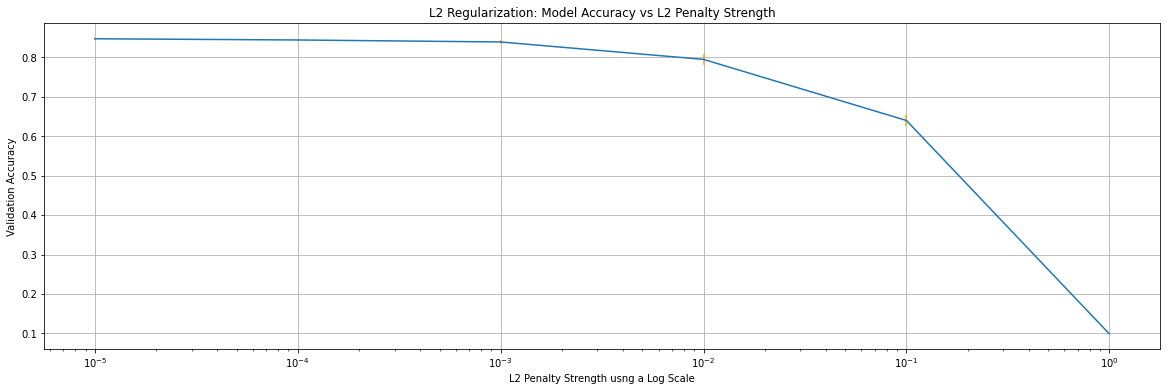

In [29]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [dic["reg_penality"] for dic in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()

# this plot is using the std of the CV splits to plot error bars however those values are so small that they aren't visable
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.xscale("log") # use a log scale for ease of reading, recall that l2_reg_penalty were in powers of 10 
plt.title("L2 Regularization: Model Accuracy vs L2 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("L2 Penalty Strength usng a Log Scale");

### Observations

Write down some observations. What do you notice from the plot?

YOUR ANSWER HERE **As the penality strangth increases the validation accuracy decreases and arrives closer to 0**


## Compare Weights between Best and Worse Model 

Next, we are going to compare the hidden layer weights between the best and worse performing model while taking note of the respective l2 penalty strengths.

In [30]:
# get the best l2 penalty term 
best_lr_penalty = grid_result.best_params_["reg_penality"]

# get the best trained model 
best_model = grid_result.best_estimator_.build_fn(Lp_reg=l2, reg_penality=best_lr_penalty)

# get the weights from the best trained model 
best_weights = best_model.get_weights()

In [31]:
# train a model using the l2_reg_penalty value at scored the lowest 
worse_l2_reg_penalty = 1.0

worse_model = build_complex_model(Lp_reg=l2, reg_penality=worse_l2_reg_penalty)

# fit model 
worse_model.fit(X_train, y_train, epochs=1)

# get weights from worse performing model 
worse_weights = worse_model.get_weights()

1875/1875 [==============================] - 5s 2ms/step - loss: 70.0269 - accuracy: 0.1403


-----
## Understanding how Weights and Biases are stored

Let's take a minute to understand that`.get_weights()` returns a list with 8 elements (if you're using `build_complex_model`).

In [32]:
len(best_weights)

8

In [33]:
len(worse_weights)

8

There are **weights matrices and bias vectors between each layer** and we have 5 layers. 

- Input
- Hidden 1
- Hidden 2
- Hidden 3
- Output 

So that means we should have 4 weight matrices, but we see 8. **There are also 4 weight vectors for the biases between each layer.** So that accounts for the 8. 


#### Index for Weight Matrices 
If you index for a weight matrix, you can see its shape and that they are indeed matrices. 

Notice how you can see the dims of the layers that the matrices are sandwiched between?

Input layer has 784 dims and hidden layer 1 has 500 dims. Given this understanding, the numbers you see in the shapes should make sense. 

In [34]:
# bewteen input and 1st hidden layer
best_weights[0].shape

(784, 500)

In [35]:
# bewteen 1st and 2nd hidden layer
best_weights[2].shape

(500, 250)

In [36]:
# bewteen 2st and 3nd hidden layer
best_weights[4].shape

(250, 100)

In [37]:
# bewteen 3rd hidden layer and output layer
best_weights[6].shape

(100, 10)

#### Index for the bias vectors

The shapes of the bias vectors should exactly match up the dims/nodes of each layer (excluding the input layer). 

In [38]:
# for hidden layer 1 
best_weights[1].shape

(500,)

In [39]:
# for hidden layer 2 
best_weights[3].shape

(250,)

In [40]:
# for hidden layer 3
best_weights[5].shape

(100,)

In [41]:
# for output layer
best_weights[7].shape

(10,)

-----

### Back to our Analysis of L2 space regularization (also known as Ridge)

Let's do a comparison of the first weight matrix (between the input and 1st hidden layer) for the best and worse performing model as well as with the initial weight values that are randomly sampled from the GlorotUniform distribution.

[**Check out the Keras docs for the Dense layer**](https://keras.io/api/layers/core_layers/dense/), you'll see that GlorotUniform is the default weight initializer. 

Before we compare weights, let's take note of the following. 

Both `best_weights[0]` or `worse_weights[0]` are matrices with shape `(784, 500)`. 

If we flatten them, then we get `784 * 500 = 392000` weights. What does this mean exactly?

Remember that we are working with the Fully Connected Forward Feeding model which looks something like this. 

![](https://pyimagesearch.com/wp-content/uploads/2016/08/simple_neural_network_header.jpg)

The important thing to notice is that in `Fully Connected` models, each component in the input vectors gets passed to all the nodes in next layer. This means for our input vector with 784 dims, there are 784 **$w_1$** weights, each with a slightly different value, one for each of the 784 components in the input vector. 

So to keep our analysis simple, we are going to just analyze one column of the weight matrix. You could index for whatever column you want, but this notebook will assume that you have indexed for the weights in column one. This means that we will compare the affect that regularization had on all of the 784 **$w_1$** weights that exist in 500 dimensional space of hidden layer 1. 

In other words, by looking at just one column, we are narrowing our analysis to the distribution of values for w_1 oppose to mixing together the distributions of all the weights w_1, w_2, ..., w_500. This is done for simplicity of analysis, the goal being to empirically observe the affect of regularization on the weights. 

In [42]:
# index for the 1st column in the 1st hidden layer weights in best_weights and save to best_hidden_weights

# index for the 1st column in the 1st hidden layer weights in worse_weights and save to worse_hidden_weights

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
# instantiate GlorotUniform and sample 500 weights and save to initial_weight_values
# hint: use shape=(500,1)

# lastly, flatten all of the above 3 variables so that you go from a matrix to a vector 
# otherwise, pandas will not like you and throw a fit 

# YOUR CODE HERE
best_hidden_weights = best_weights[0][0].flatten()
worse_hidden_weights = worse_weights[0][0].flatten()
initializer = GlorotUniform(seed=1234)
initial_weight_values = initializer(shape=(500,1)).numpy().flatten()

In [43]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df = pd.DataFrame(data=data).T
df.columns = cols

In [44]:
# check out the statistics for each weight column 
df.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,5.000000e+02,500.000000
mean,-0.001782,-5.544224e-09,0.002079
std,0.039267,1.075617e-07,0.061731
min,-0.068015,-1.709256e-06,-0.109263
25%,-0.036411,-3.382737e-18,-0.047005
50%,0.000693,2.014674e-22,0.001182
75%,0.030632,4.005930e-18,0.055509
max,0.068347,3.492583e-07,0.109095


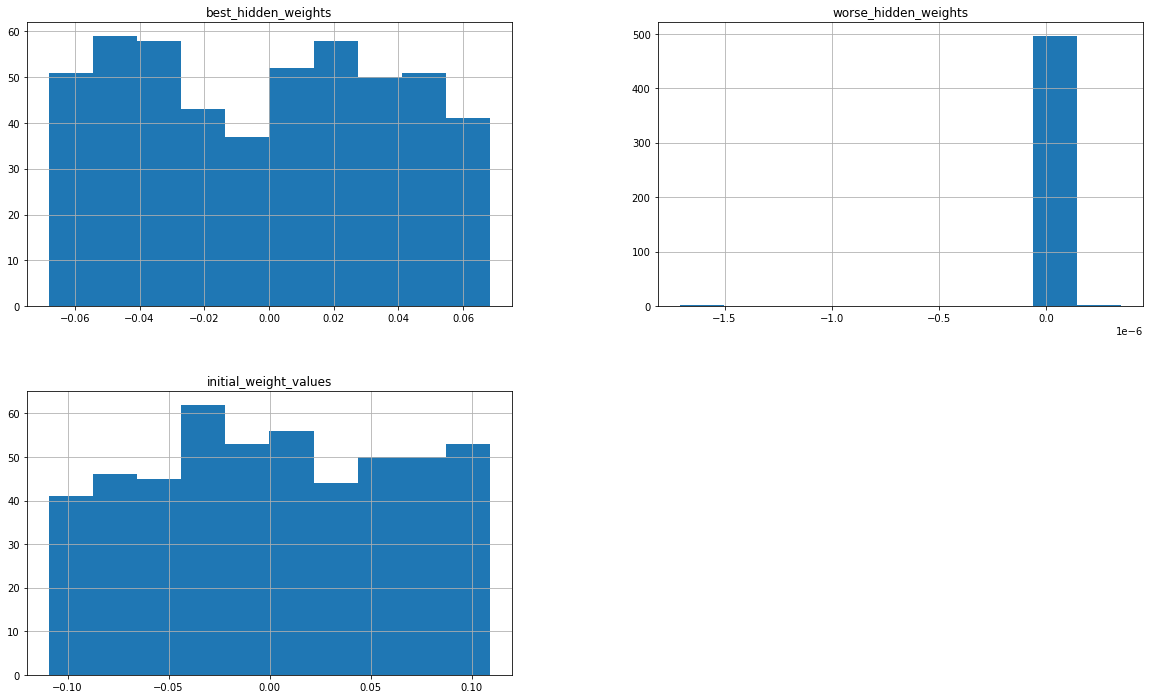

In [45]:
# plot the distributions for each weight column 
df.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

YOUR ANSWER HERE Hidden layer weights are slightly higher

**What was the effect of using a small l2 penalty value?**

YOUR ANSWER HERE **if penality is small the the weight is too less and may not still overcome the overfit**

**What was the effect of using a large l2 penalty value?**

YOUR ANSWER HERE **If the penality is very large it will add too much weight and thus may result in underfitting**

**Given what you know about L2 regularization, are you surprised by these results?**

YOUR ANSWER HERE

----

# Experiment 2: Identify the relationship between model performance and Max Norm Weight Constraint

![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

Recall from lecture that the **Norm** of a vector is just another word for the **length** of a vector.

MaxNorm weight constraint puts a limit on the length of a weight vector.

$$ \text{Max_value_of_norm} >= {\displaystyle \left\|x\right\|_{p}=\left(|x_{1}|^{p}+|x_{2}|^{p}+\dotsb +|x_{n}|^{p}\right)^{1/p}.}$$  

The effect that Lp regularization and Max Norm Weight Constraint have on the weights should be the same, but they go about it in different ways. 

Lp regularization (l1/Lasso and l2/Ridge) shrink the value of the weights. Where as Max Norm Weight Constraint puts a limit on how big the weight vector can be which, in effect, keeps the individual weight values small enough to keep the norm below that limit. 

In this experiment, we are going to run another gridseach but instead of using Lp space regularization as we did in the previous experiment, we are going to use MaxNorm and see what kind of effect that this type of regularization has on model performance and the learned weights. 

Since we already built our model, we just need to update the `hyper_parameters` dictionary. 

In [46]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    
    "maxnorm_wc":[ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
         6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ] , 
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearche run-time are too long for you    
    "epochs": [1] 
}

hyper_parameters

{'epochs': [1],
 'maxnorm_wc': [0.5,
  1.0,
  1.5,
  2.0,
  2.5,
  3.0,
  3.5,
  4.0,
  4.5,
  5.0,
  5.5,
  6.0,
  6.5,
  7.0,
  7.5,
  8.0,
  8.5,
  9.0,
  9.5,
  10.0]}

In [47]:
np.linspace(0.5, 10.0, num=20)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [48]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=2)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


938/938 [==============================] - 2s 2ms/step - loss: 0.4539 - accuracy: 0.8326


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  4.0min finished


1875/1875 [==============================] - 5s 2ms/step - loss: 0.5948 - accuracy: 0.7848


In [49]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 4.06 mins


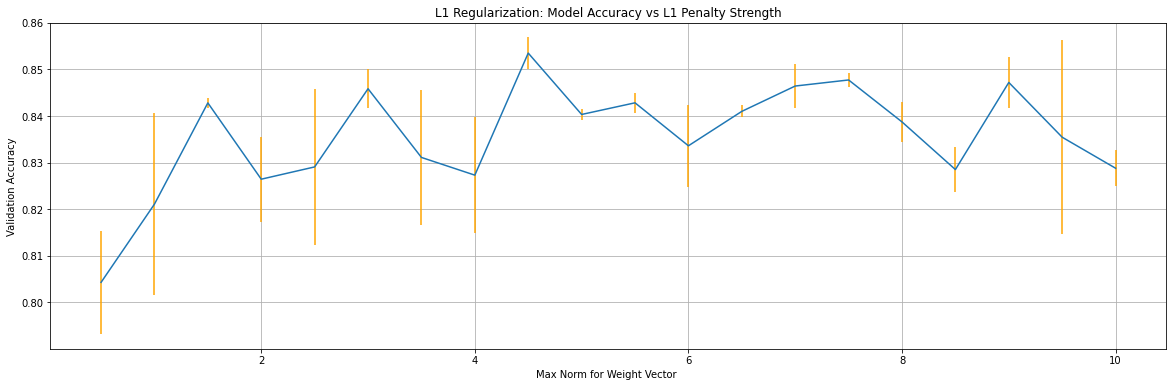

In [50]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [dic["maxnorm_wc"] for dic in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.title("L1 Regularization: Model Accuracy vs L1 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("Max Norm for Weight Vector ");

In [51]:
# get the best l2 penalty term from grid and save to best_max_norm_val

# get the best trained model from grid and save to best_model

# get the weights from the best trained model and save to best_weights

# YOUR CODE HERE
best_max_norm_val = best_lr_penalty
best_model = best_model
best_weights = best_weights

In [52]:
best_max_norm_val

1e-05

In [53]:
# we see that the norm of our weights are indeed below the maximum allowed value 
np.linalg.norm(best_weights[0][0])

0.8780622

In [54]:
# train a model using the max_norm_val value that scored the lowest 

# build a model using build_complex_model and worse_max_norm_val and save it to worse_model

# fit model 

# get weights from worse performing model 


# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: ignored

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [56]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df_maxnorm= pd.DataFrame(data=data).T
df_maxnorm.columns = cols

In [57]:
df_maxnorm.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,5.000000e+02,500.000000
mean,-0.001782,-5.544224e-09,0.002079
std,0.039267,1.075617e-07,0.061731
min,-0.068015,-1.709256e-06,-0.109263
25%,-0.036411,-3.382737e-18,-0.047005
50%,0.000693,2.014674e-22,0.001182
75%,0.030632,4.005930e-18,0.055509
max,0.068347,3.492583e-07,0.109095


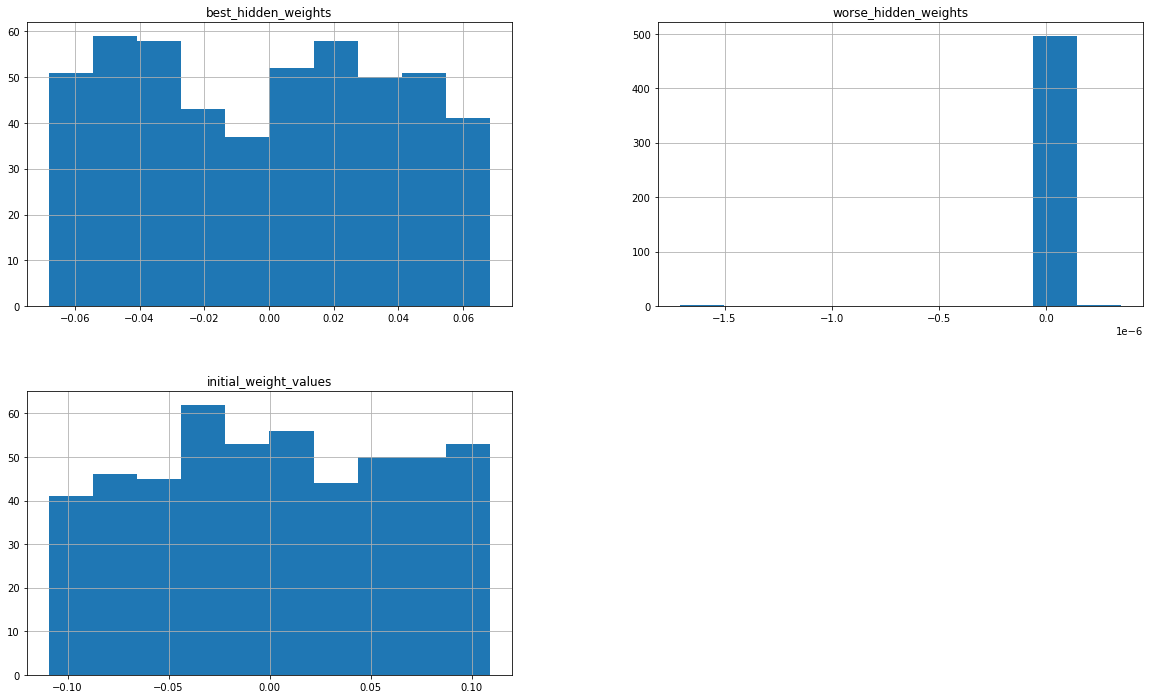

In [58]:
# plot the distributions for each weight column 
df_maxnorm.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

YOUR ANSWER HERE

**What was the effect of using the weight constraint value in MaxNorm in the best performing model?**

YOUR ANSWER HERE

**What was the effect of using the weight constraint value in MaxNorm in the worse performing model?**

YOUR ANSWER HERE

**Given what you know about MaxNorm regularization, are you surprised by these results?**

YOUR ANSWER HERE

-----
# Experiment 3: Identify the relationship between model performance and Dropout


![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

In the 3rd and final experiment, we will use gridsearch to see how model performance is affect by varying the value of the the dropout probability. 

Recall from lecture that dropout tends to perform best when used with weight constraint. Since this is the case, we will gridsearch both dropout probability and the weight constraint for MaxNorm. 

If interested, feel free to read through the original publication on [**Drop Out**](https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf). 

**Key Take aways:** 

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in. 
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm


In [59]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(0.5, 5, num=10),
    # take note that l1_reg_penalty values are in powers of 10 
    "dropout_prob": np.linspace(0.0, 0.6, num=7), 
    "epochs": [1] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}

hyper_parameters

{'dropout_prob': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 'epochs': [1],
 'maxnorm_wc': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])}

In [60]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


625/625 [==============================] - 1s 2ms/step - loss: 0.5789 - accuracy: 0.7872


[Parallel(n_jobs=-2)]: Done 210 out of 210 | elapsed: 22.7min finished


1875/1875 [==============================] - 5s 2ms/step - loss: 0.6069 - accuracy: 0.7835


In [61]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 22.8 mins


In [62]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [dic["dropout_prob"] for dic in params]

Since there are 2 indepdent variables this time around (dropout_prob and maxnorm_wc) which affect the validation accuracy, it's best to use a different plot. A heat map will work. 

In [63]:
dropout_prob_list = [  dic["dropout_prob"]  for dic in params]
maxnorm_wc_list = [  dic["maxnorm_wc"]  for dic in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

# pivot dataframe in preperation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")

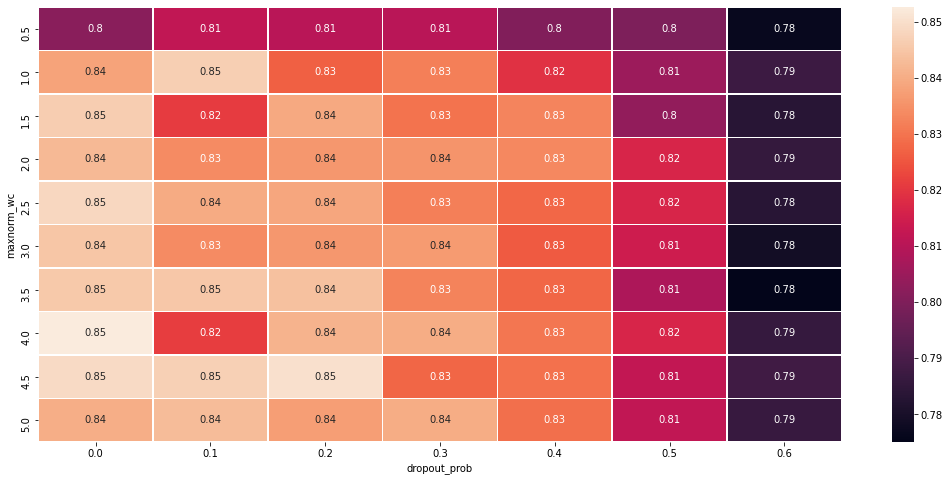

In [64]:
# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax);

### Observations 

We can see the dropout probabilities in the horizontal axis and the maxnorm weight constraint values in the virtical axis. The values in the cells are the validation accuracy that corresponds to a pair of regularization values.

Take a look at the heat map and answer the following questions. Note that depending on which model you used (the simple or complex one) your answers might be different from that of others. 

**What range of dropout probability values tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**What range of maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE 2.5

**When taken together, what pair of dropout probability and maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE maxnorm : 2.5 and dropout prob:0.0


**Do you think that using dropout was helpful in increasing model performance?**

YOUR ANSWER HERE only slightly

-----
# Stretch Goals for $L_p$ Space section

Here are some ideas that you can explore using the custom distance metric class that you have built. Though if you think of something else, go for it!

- Run a similar experiment but instead of comparing L2 between Keras and our custom class, compare L1 (Lasso) 
- Run a similar experiment but instead of comparing L2 between Keras and our custom class, compare L1_L2 (Elastic Net) 
- Run a gridsearch across several different Lp distance metrics and strengths and see which Lp distance leads to the best performing model
    - Consider selecting a p range between **[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, ..., 10]** step size of 0.5
    - Consider selecting a p range between **[1, 10, 100, 1000, 10000]** step size in powers of 10

_____

### Experiment 4: Train, Save, and Load a Keras model

Let's get some practice with how to save and load trained Keras models 

For this experiment, review the section on Saving and Loading models from the guided project in order to help you to: 

- Build a model of your choosing
- Gridsearch the model with a method of your choosing
- Save the trained model to file
- Load the trained model from file
- Just as we did in the Guided Project, evalute the loaded model using a test set and make sure the results of the loaded model match that of the saved model 